# Import Modules

In [1]:
import importlib
import os
import sys

import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns

os.chdir("../")
sys.path.insert(0, os.getcwd())

In [2]:
from morai.dashboard.utils import dashboard_helper as dh
from morai.experience import charters, credibility, eda, tables
from morai.forecast import metrics, models, preprocessors
from morai.utils import custom_logger, helpers

In [3]:
# update log level if wanting more logging
custom_logger.set_log_level("INFO")

In [4]:
pd.options.display.float_format = "{:,.2f}".format

# Data

In [5]:
pl_parquet_path = r"files\partition\*\*\*.parquet"

In [11]:
variables = [
    "Observation_Year",
    "Sex",
    "Smoker_Status",
    "Insurance_Plan",
    "Issue_Age",
    "Duration",
    "Face_Amount_Band",
    "Issue_Year",
    "Attained_Age",
    "SOA_Post_Lvl_Ind",
    "Number_of_Pfd_Classes",
    "Preferred_Class",
]
measures = [
    "Amount_Exposed",
    "Policies_Exposed",
    "Death_Claim_Amount",
    "Death_Count",
    # "Cen2MomP1wMI_byAmt",
    # "Cen2MomP2wMI_byAmt",
]
columns_needed = variables + measures
columns_not_needed = [
    "SOA_Antp_Lvl_TP",
    "SOA_Guar_Lvl_TP",
    "MIB_Flag",
    "Preferred_Indicator",
    "Slct_Ult_Ind",
    "ExpDth_Amt_VBT2015",
    "ExpDth_Amt_VBT2015wMI",
    "ExpDth_Cnt_VBT2015",
    "ExpDth_Cnt_VBT2015wMI",
    "Cen3MomP1wMI_byAmt",
    "Cen3MomP2wMI_byAmt",
    "Cen3MomP3wMI_byAmt",
]

In [7]:
# reading in the dataset
# the partitioned columns need to be casted back correctly
pl.enable_string_cache()
lzdf = pl.scan_parquet(
    pl_parquet_path,
).cast({"Sex": pl.Categorical})

In [8]:
initial_row_count = lzdf.select(pl.len()).collect().item()
print(
    f"row count: {initial_row_count} \n"
    f"exposures: {lzdf.select([pl.col('Amount_Exposed').sum()]).collect()[0,0]}"
)

row count: 55432120 
exposures: 128443264094328.8


In [9]:
no_values = (
    (pl.col("Amount_Exposed") != 0)
    | (pl.col("Policies_Exposed") != 0)
    | (pl.col("Death_Claim_Amount") != 0)
    | (pl.col("Death_Count") != 0)
)
updated_row_count = lzdf.filter(no_values).select(pl.len()).collect().item()
print(
    f"removing cells with no claim or exposure which was: {initial_row_count-updated_row_count} cells."
)

removing cells with no claim or exposure which was: 292288 cells.


## Filters

### Core

In [10]:
# used in ILEC report
core_filters = (
    (pl.col("Observation_Year") >= 2012)
    & (pl.col("Issue_Age") > 17)
    & (pl.col("SOA_Post_Lvl_Ind") != "PLT")
    & (pl.col("Insurance_Plan") != "Other")
    & (pl.col("Issue_Year") >= 2000)
    & (pl.col("Smoker_Status") != "U")
    & (
        ~pl.col("Face_Amount_Band").is_in(
            (
                "01: 0 - 9,999",
                "02: 10,000 - 24,999",
                "03: 25,000 - 49,999",
                "04: 50,000 - 99,999",
            )
        )
    )
)

### Base

In [11]:
# less strict filter allowing 1980+ and all face bands
base_filters = (
    (pl.col("Observation_Year") >= 2012)
    & (pl.col("Issue_Age") > 17)
    & (pl.col("SOA_Post_Lvl_Ind") != "PLT")
    & (pl.col("Insurance_Plan") != "Other")
    & (pl.col("Issue_Year") >= 1980)
    & (pl.col("Smoker_Status") != "U")
)

## Grouped Datasets

Grouped dataset is grouped on certain variables to limit the amount of memory that is stored when having the entire dataset

### Grouped

In [12]:
# parquet files read 4 - 10x faster
# polars is faster (25 secs)
grouped_df = (
    lzdf.group_by(variables)
    .agg([pl.col(measure).sum() for measure in measures])
    .filter(no_values)
    .filter(base_filters)
    .collect()
)

In [13]:
grouped_df = grouped_df.to_pandas()

In [14]:
grouped_df = helpers.clean_df(grouped_df)

 2024-06-16 23:01:16 | morai.utils.helpers | INFO     | lowercasing the column names 
 2024-06-16 23:01:17 | morai.utils.helpers | INFO     | replacing spaces with underscores in the column names 
 2024-06-16 23:01:17 | morai.utils.helpers | INFO     | removed unused categories and reorder 
 2024-06-16 23:01:31 | morai.utils.helpers | INFO     | update index to int32 
 2024-06-16 23:01:31 | morai.utils.helpers | INFO     | dataFrame shape: (17934144, 16) 


In [15]:
grouped_df = grouped_df.sample(frac=0.1)

In [16]:
# try to keep below 5M on a 16GB RAM
grouped_df.shape

(1793414, 16)

In [17]:
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1793414 entries, 8904156 to 11259695
Data columns (total 16 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   observation_year       int64   
 1   sex                    category
 2   smoker_status          category
 3   insurance_plan         category
 4   issue_age              int32   
 5   duration               int32   
 6   face_amount_band       category
 7   issue_year             int32   
 8   attained_age           int32   
 9   soa_post_lvl_ind       category
 10  number_of_pfd_classes  category
 11  preferred_class        category
 12  amount_exposed         float64 
 13  policies_exposed       float64 
 14  death_claim_amount     int64   
 15  death_count            int64   
dtypes: category(7), float64(2), int32(4), int64(3)
memory usage: 114.6 MB


In [18]:
helpers.memory_usage_df(grouped_df)

Total memory usage: 114.5956678390503 mb
Column consuming the most memory: observation_year
Memory usage per column:
Index                     7173656
observation_year         14347312
sex                       1793638
smoker_status             1793639
insurance_plan            1793948
issue_age                 7173656
duration                  7173656
face_amount_band          1794564
issue_year                7173656
attained_age              7173656
soa_post_lvl_ind          1793826
number_of_pfd_classes     1793877
preferred_class           1793935
amount_exposed           14347312
policies_exposed         14347312
death_claim_amount       14347312
death_count              14347312
dtype: int64


In [19]:
nan_counts = grouped_df.isna().sum()
nan_counts

observation_year         0
sex                      0
smoker_status            0
insurance_plan           0
issue_age                0
duration                 0
face_amount_band         0
issue_year               0
attained_age             0
soa_post_lvl_ind         0
number_of_pfd_classes    0
preferred_class          0
amount_exposed           0
policies_exposed         0
death_claim_amount       0
death_count              0
dtype: int64

## Enhance Dataset

### Add Mortality Table

In [20]:
vbt_table = tables.MortTable(preset="vbt15").df

 2024-06-16 23:01:35 | morai.experience.tables | INFO     | Grid size: 59536 combinations. 
 2024-06-16 23:01:35 | morai.experience.tables | INFO     | Creating grid with dimensions: ['issue_age', 'duration', 'sex', 'smoker_status'] 
 2024-06-16 23:01:36 | morai.experience.tables | INFO     | Removed '29524' rows where attained_age, issue_age, or duration was invalid. 
 2024-06-16 23:01:39 | morai.experience.tables | INFO     | Created table that has the following dims: {'issue_age': range(0, 122), 'duration': range(1, 123), 'sex': ['F', 'M'], 'smoker_status': ['NS', 'S']} 
 2024-06-16 23:01:39 | morai.experience.tables | INFO     | Table has 30012 cells. 
 2024-06-16 23:01:39 | morai.experience.tables | INFO     | tables: [3224, 3234, 3252, 3262] 
 2024-06-16 23:01:39 | morai.experience.tables | INFO     | juveniles: [3273, 3273, 3274, 3274] 
 2024-06-16 23:01:39 | morai.experience.tables | INFO     | extend: True, filled in 488 missing values. 


In [21]:
merge_keys = ["issue_age", "duration", "sex", "smoker_status", "attained_age"]
grouped_df = grouped_df.merge(vbt_table, on=merge_keys, how="left")
grouped_df = grouped_df.rename(columns={"vals": "qx_vbt15"})

### Calculated Fields

In [14]:
grouped_df["qx_raw"] = np.where(
    grouped_df["amount_exposed"] == 0,
    0,
    grouped_df["death_claim_amount"] / grouped_df["amount_exposed"],
)

In [15]:
print(
    f"There were {len(grouped_df[grouped_df['qx_raw']>1])} records that were greater than 1. This should not happen with annual exposure method. Capping at 1"
)
print(
    f"There were {len(grouped_df[grouped_df['amount_exposed']==0])} records that had 0 exposure with a claim or a policy count. This shouldn't happen"
)
grouped_df["qx_raw"] = grouped_df["qx_raw"].clip(upper=1)
grouped_df["qx_log_raw"] = np.log(grouped_df["qx_raw"] + 1)
grouped_df["exp_amt_vbt15"] = grouped_df["qx_vbt15"] * grouped_df["amount_exposed"]
grouped_df["ae_vbt15"] = np.where(
    grouped_df["amount_exposed"] == 0,
    0,
    grouped_df["death_claim_amount"] / grouped_df["exp_amt_vbt15"],
)

There were 3661 records that were greater than 1. This should not happen with annual exposure method. Capping at 1
There were 40 records that had 0 exposure with a claim or a policy count. This shouldn't happen


In [84]:
grouped_df["class_enh"] = (
    grouped_df["number_of_pfd_classes"].astype(str)
    + "_"
    + grouped_df["preferred_class"].astype(str)
).astype("category")

In [98]:
# write to file for predictive model
# check if sex and smoker_status are categorical or if it changed
grouped_df.to_parquet("files/dataset/mortality_grouped.parquet")

## Load Data

In [5]:
pl_parquet_path = r"files\dataset\mortality_grouped.parquet"

In [6]:
# reading in the dataset
# `enable_string_cache` helps with categorical type values
# casting columns to categorical (shouldn't need to do this, but it was changed in aggregation)
pl.enable_string_cache()
lzdf = pl.scan_parquet(
    pl_parquet_path,
).cast(
    {
        "sex": pl.Categorical,
        "smoker_status": pl.Categorical,
    }
)

In [7]:
initial_row_count = lzdf.select(pl.len()).collect().item()
print(
    f"row count: {initial_row_count} \n"
    f"exposures: {lzdf.select([pl.col('amount_exposed').sum()]).collect()[0,0]}"
)

row count: 1793414 
exposures: 9882883284164.027


In [8]:
grouped_df = lzdf.collect()

In [9]:
grouped_df = grouped_df.to_pandas()

# Exploratory

In [87]:
variables = [variable.lower() for variable in variables + ["class_enh"]]
measures = [measure.lower() for measure in measures]

## Descriptive

### Numeric

In [88]:
desc = grouped_df.describe()
desc.loc["sum"] = grouped_df.select_dtypes(include=[np.number]).sum()
desc

observation_year     issue_age      duration       issue_year  \
count      1,793,414.00  1,793,414.00  1,793,414.00     1,793,414.00   
mean           2,015.85         44.89         12.57         2,003.78   
std                2.31         15.59          8.35             8.40   
min            2,012.00         18.00          1.00         1,981.00   
25%            2,014.00         32.00          6.00         1,999.00   
50%            2,016.00         44.00         11.00         2,005.00   
75%            2,018.00         56.00         18.00         2,010.00   
max            2,019.00        100.00         39.00         2,019.00   
sum    3,615,245,848.00 80,509,614.00 22,545,554.00 3,593,613,123.00   

        attained_age       amount_exposed  policies_exposed  \
count   1,793,414.00         1,793,414.00      1,793,414.00   
mean           56.46         5,510,653.58             16.95   
std            16.76        28,120,388.86             56.13   
min            18.00                 0.00              0.00   
25%            44.00            92,191.75              0.74   
50%            56.00           491,984.77              2.09   
75%            69.00         2,394,053.56              8.41   
max           120.00     1,953,777,480.01          1,519.34   
sum   101,261,754.00 9,882,883,284,164.03     30,397,169.43   

       death_claim_amount  death_count     qx_vbt15       qx_raw  \
count        1,793,414.00 1,793,414.00 1,793,414.00 1,793,414.00   
mean            13,911.34         0.09         0.01         0.01   
std            209,935.89         0.63         0.03         0.08   
min                  0.00         0.00         0.00         0.00   
25%                  0.00         0.00         0.00         0.00   
50%                  0.00         0.00         0.00         0.00   
75%                  0.00         0.00         0.01         0.00   
max         75,000,000.00        38.00         0.50         1.00   
sum     24,948,791,235.00   169,545.00    21,976.64    17,721.63   

          exp_amt_vbt15     ae_vbt15   qx_log_raw   _aggregate  
count      1,793,414.00 1,793,414.00 1,793,414.00 1,793,414.00  
mean          15,318.77         1.17         0.01         1.00  
std           73,221.22        72.13         0.06         0.00  
min                0.00         0.00         0.00         1.00  
25%              242.51         0.00         0.00         1.00  
50%            1,421.11         0.00         0.00         1.00  
75%            7,274.70         0.00         0.00         1.00  
max        8,802,165.92    80,899.07         0.69         1.00  
sum   27,472,904,454.16 2,106,103.17    14,223.16 1,793,414.00

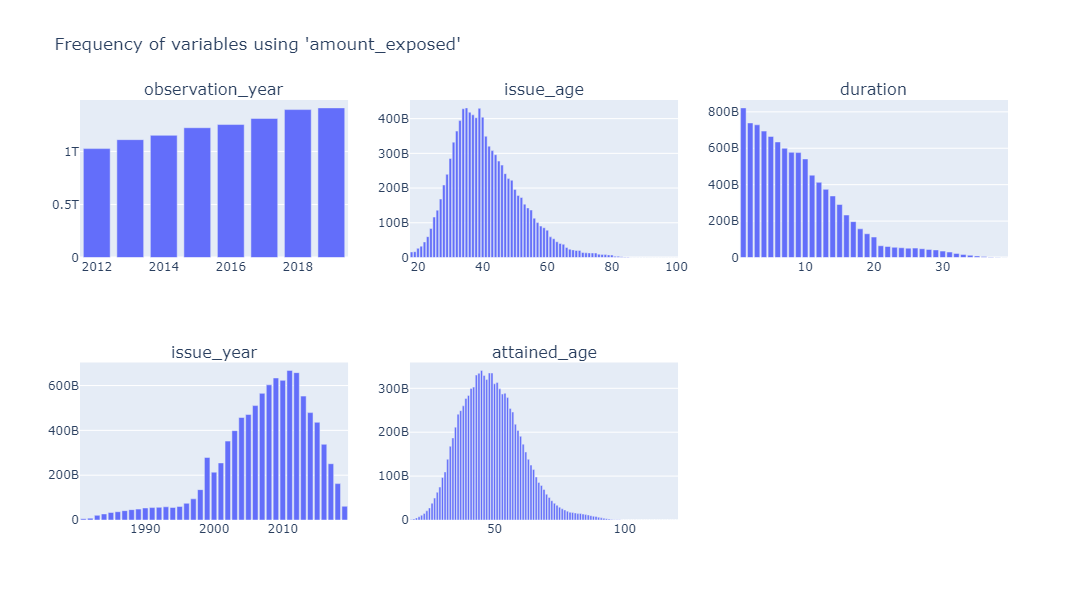

In [89]:
charters.frequency(
    grouped_df,
    cols=3,
    features=grouped_df[variables].select_dtypes(include=["number"]).columns.tolist(),
    sum_var="amount_exposed",
).show()

### Categorical

 2024-06-19 13:43:41 | morai.experience.charters | INFO     | No features provided, using all non-numeric features. 


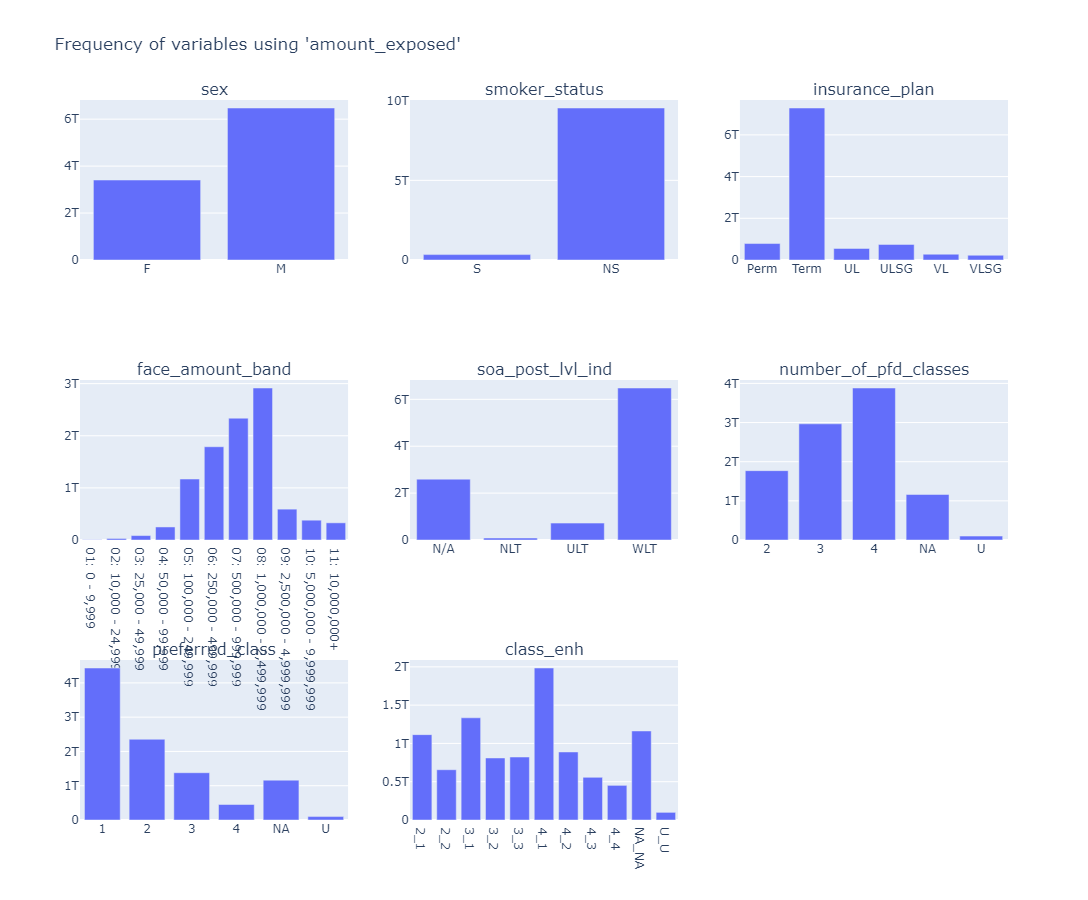

In [90]:
charters.frequency(grouped_df, cols=3, sum_var="amount_exposed").show()

### Target

 2024-06-19 13:44:06 | morai.experience.charters | INFO     | Creating '14' target plots. 


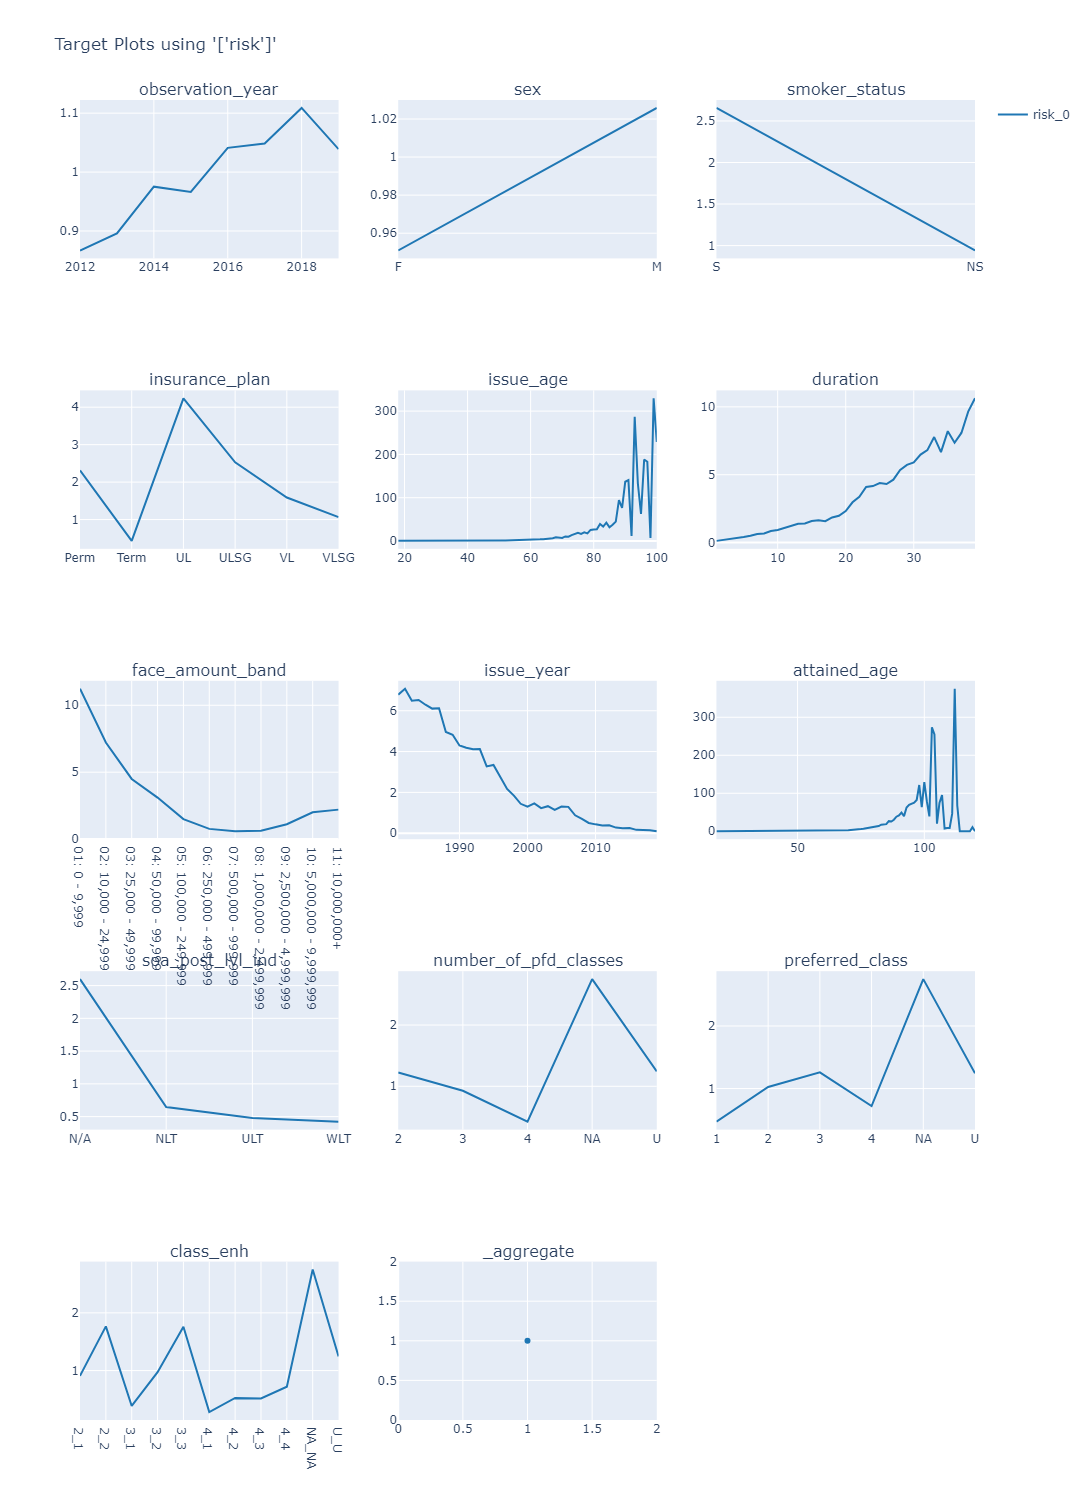

In [92]:
charters.target(
    df=grouped_df,
    target="risk",
    cols=3,
    features=variables,
    numerator=["death_claim_amount"],
    denominator=["amount_exposed"],
).show()

 2024-06-17 00:08:25 | morai.experience.charters | INFO     | Creating '66' target plots. 


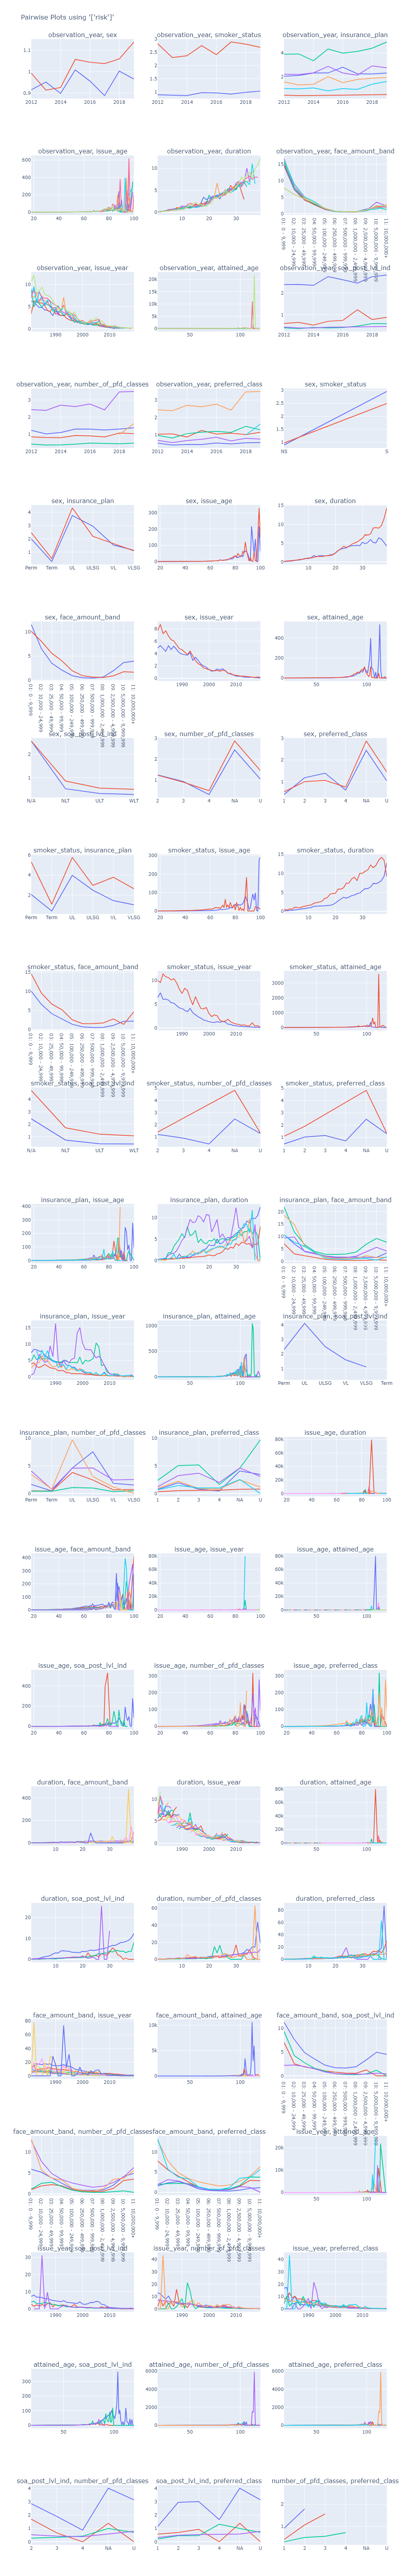

In [95]:
charters.target(
    df=grouped_df,
    target="risk",
    cols=3,
    features=variables,
    numerator=["death_claim_amount"],
    denominator=["amount_exposed"],
    pairwise=True,
).show()

### Other

Correlation provides the relationship that two features have together. A correlation of 1 indicates they move in the same direction, and a correlation of 0 indicates they do not have a relationship.

 2024-06-15 15:06:58 | morai.experience.eda | INFO     | Creating correlation matrix for numeric features using method: 'kendall'. 


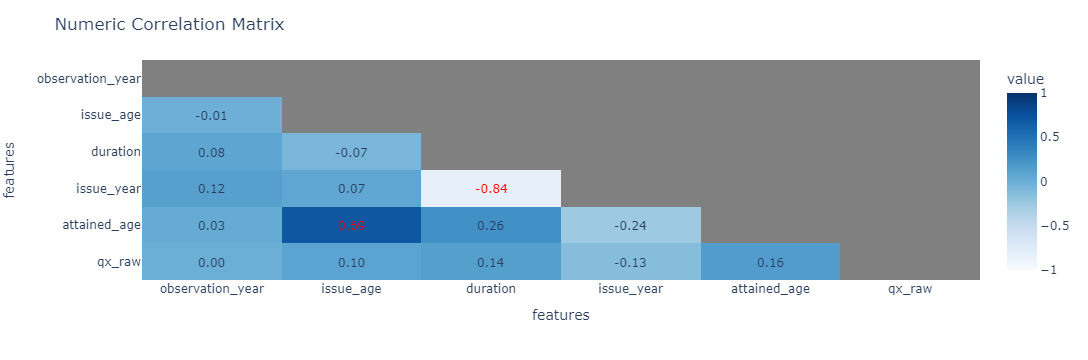

In [122]:
corr_num = eda.correlation(
    df=grouped_df, features=variables + ["qx_raw"], method="kendall", numeric=True
)
charters.matrix(df=corr_num, threshold=0.5, title="Numeric Correlation Matrix")

 2024-06-19 13:44:50 | morai.experience.eda | INFO     | Creating correlation matrix for categorical features using cramers_v.  


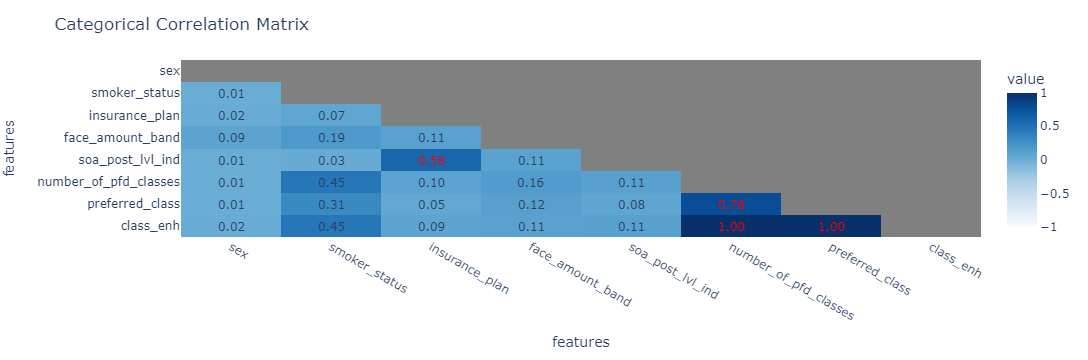

In [93]:
corr_cat = eda.correlation(
    df=grouped_df, features=variables + ["qx_raw"], method="kendall", numeric=False
)
charters.matrix(df=corr_cat, threshold=0.5, title="Categorical Correlation Matrix")

Mutual information is similar to correlation and determines the strength of two variables relationship

 2024-06-19 13:45:17 | morai.experience.eda | INFO     | Calculating the mutual information for '13' columns using 'regression' that will result in '78' combinations. 
 2024-06-19 13:45:17 | morai.experience.eda | INFO     | Using up to '10' parallel jobs for the computation. 


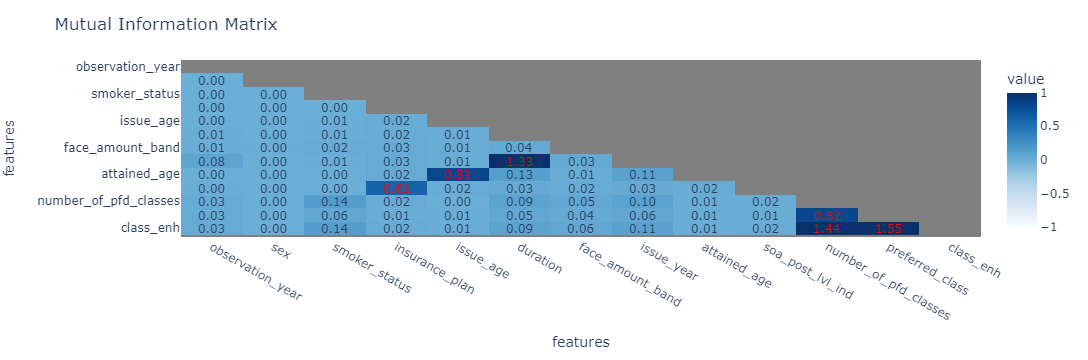

In [94]:
mi = eda.mutual_info(
    df=grouped_df,
    features=variables,
    n_jobs=10,
)
charters.matrix(df=mi, threshold=0.3, title="Mutual Information Matrix")

GVIF determines the amount of multicollinearity the features have. A value of 5 or 10 are standard thresholds.

In [97]:
# these features cause gvif to be too high
# "number_of_pfd_classes"
# "preferred_class"

gvif = eda.gvif(
    df=grouped_df,
    features=[
        "attained_age",
        "observation_year",
        "issue_age",
        "smoker_status",
        "sex",
        "class_enh",
        "insurance_plan",
    ],
    numeric_only=False,
)
gvif

 2024-06-19 14:18:41 | morai.experience.eda | DEBUG    | Adding a constant column 'constant'. 
 2024-06-19 14:18:41 | morai.experience.eda | INFO     | Converting '4' categorical features to dummy variables. 
 2024-06-19 14:18:41 | morai.experience.eda | INFO     | Calculating the GVIF for '7' features. 
 2024-06-19 14:18:41 | morai.experience.eda | DEBUG    | Calculating GVIF for 'attained_age' 
 2024-06-19 14:18:43 | morai.experience.eda | DEBUG    | Calculating GVIF for 'observation_year' 
 2024-06-19 14:18:44 | morai.experience.eda | DEBUG    | Calculating GVIF for 'issue_age' 
 2024-06-19 14:18:46 | morai.experience.eda | DEBUG    | Calculating GVIF for 'smoker_status' 
 2024-06-19 14:18:51 | morai.experience.eda | DEBUG    | Calculating GVIF for 'sex' 
 2024-06-19 14:18:56 | morai.experience.eda | DEBUG    | Calculating GVIF for 'class_enh' 
 2024-06-19 14:19:00 | morai.experience.eda | DEBUG    | Calculating GVIF for 'insurance_plan' 


feature  gvif
0      attained_age  4.97
1  observation_year  1.06
2         issue_age  4.85
3     smoker_status  1.13
4               sex  1.00
5         class_enh  1.02
6    insurance_plan  1.01

## Mortality Explore

Mortality qx seems to be increasing by observation year, however as we shall see this is just a function of age

 2024-05-13 23:47:38 | morai.experience.charters | INFO     | Calculating ratio using [death_claim_amount] and [amount_exposed] 


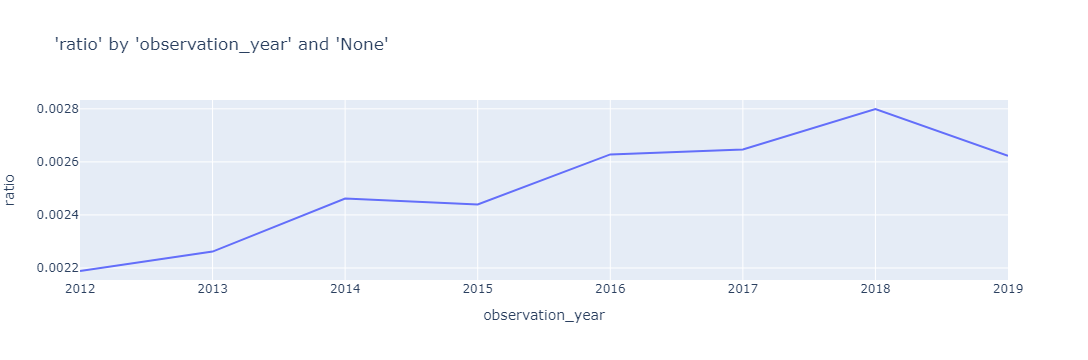

In [37]:
charters.chart(
    df=grouped_df,
    x_axis="observation_year",
    y_axis="ratio",
    color=None,
    type="line",
    numerator="death_claim_amount",
    denominator="amount_exposed",
)

 2024-06-18 00:32:47 | morai.experience.charters | INFO     | Calculating risk using [death_claim_amount] and [amount_exposed] 


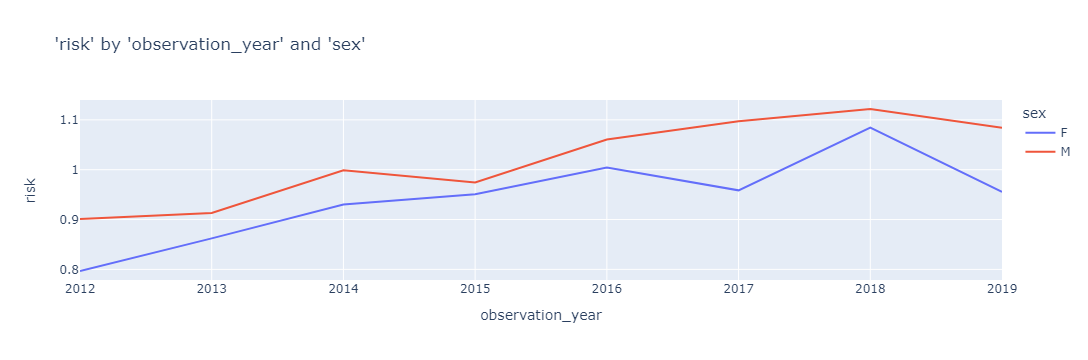

In [13]:
charters.chart(
    df=grouped_df,
    x_axis="observation_year",
    y_axis="risk",
    color="sex",
    type="line",
    numerator="death_claim_amount",
    denominator="amount_exposed",
)

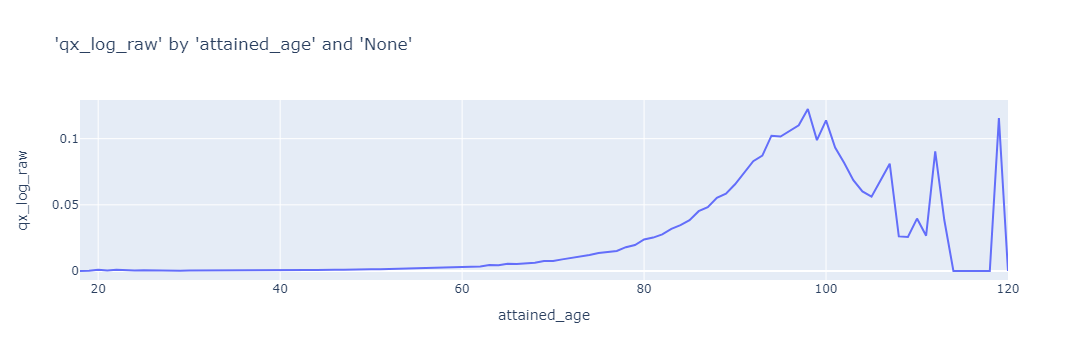

In [78]:
charters.chart(
    df=grouped_df,
    x_axis="attained_age",
    y_axis="qx_log_raw",
    type="line",
    agg="mean",
)

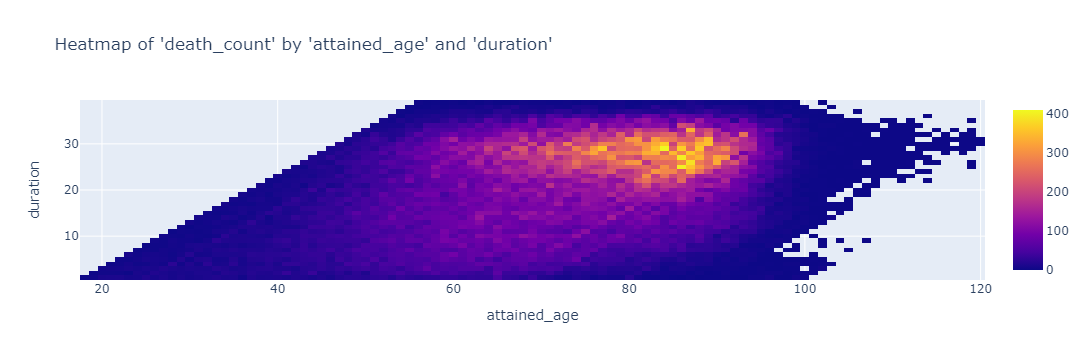

In [38]:
charters.chart(
    df=grouped_df,
    x_axis="attained_age",
    y_axis="duration",
    color="death_count",
    type="heatmap",
)

 2024-05-13 23:47:50 | morai.experience.charters | INFO     | Binning feature: [attained_age] with 11 bins 


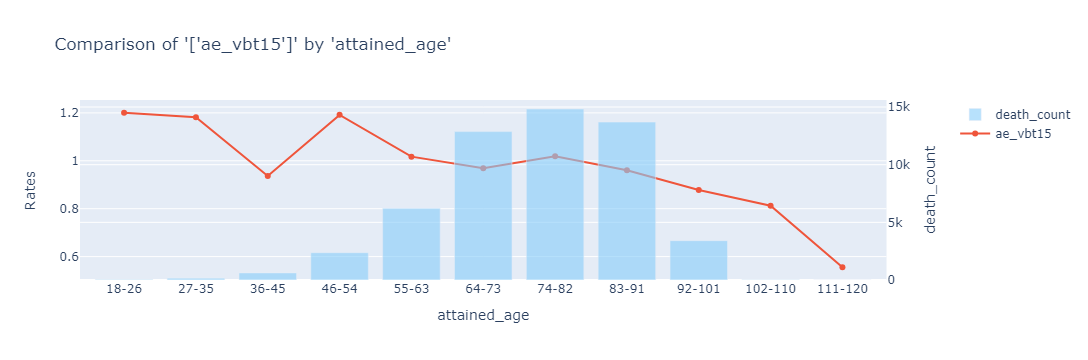

In [39]:
charters.compare_rates(
    grouped_df[grouped_df["insurance_plan"].isin(["UL", "ULSG"])],
    x_axis="attained_age",
    rates=["ae_vbt15"],
    weights=["exp_amt_vbt15"],
    secondary="death_count",
    y_log=False,
    x_bins=11,
    display=True,
)

 2024-05-13 23:48:16 | morai.experience.charters | INFO     | Binning feature: [duration] with 11 bins 


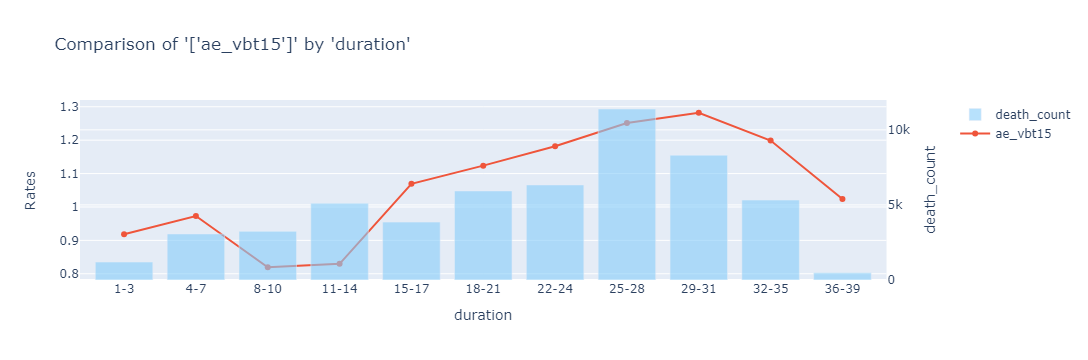

In [40]:
charters.compare_rates(
    grouped_df[grouped_df["insurance_plan"].isin(["UL", "ULSG"])],
    x_axis="duration",
    rates=["ae_vbt15"],
    weights=["exp_amt_vbt15"],
    secondary="death_count",
    y_log=False,
    x_bins=11,
    display=True,
)

 2024-06-11 22:31:34 | morai.experience.credibility | INFO     | Credibility calculated using 'limited fluctuation' on 'death_count'.
Dataframe does not need to be seriatim.
Created column 'credibility_lf'.
Full credibility threshold: 1,082.2
Probability measure within range: 0.9
Range +/-: 0.1
Standard deviation: 1.0
Mean: 1.0 


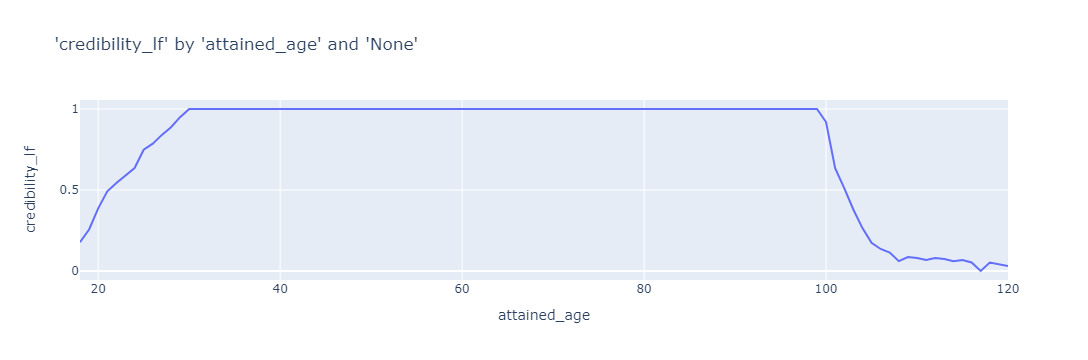

In [64]:
charters.chart(
    df=credibility.limited_fluctuation(
        df=grouped_df, measure="death_count", groupby_cols=["attained_age"]
    ),
    x_axis="attained_age",
    y_axis="credibility_lf",
    type="line",
)

 2024-06-11 22:31:21 | morai.experience.credibility | INFO     | Credibility calculated using 'asymptotic' on 'death_count'.
Dataframe does not need to be seriatim.
Created column 'credibility_as'.
Constant k: 270. 


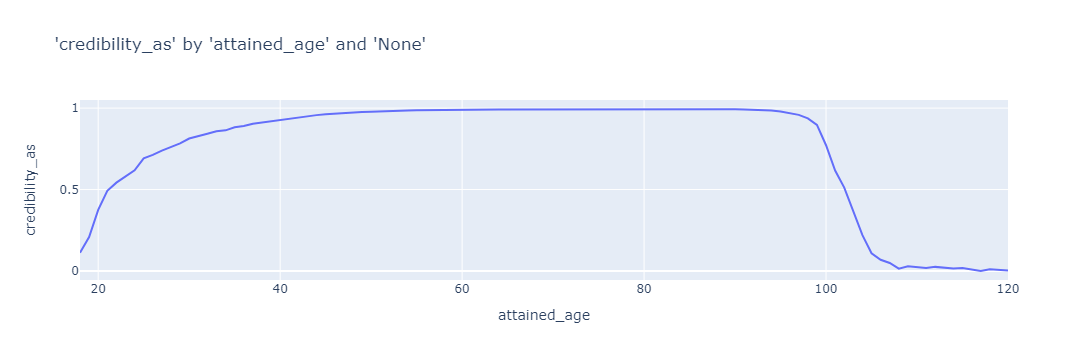

In [63]:
charters.chart(
    df=credibility.asymptotic(
        df=grouped_df, measure="death_count", groupby_cols=["attained_age"]
    ),
    x_axis="attained_age",
    y_axis="credibility_as",
    type="line",
)

 2024-06-11 22:30:26 | morai.experience.credibility | INFO     | Credibility calculated using 'SOA VM-20 approximation'.
Created column 'credibility_vm20_approx'.
Dataframe does not need to be seriatim.
 


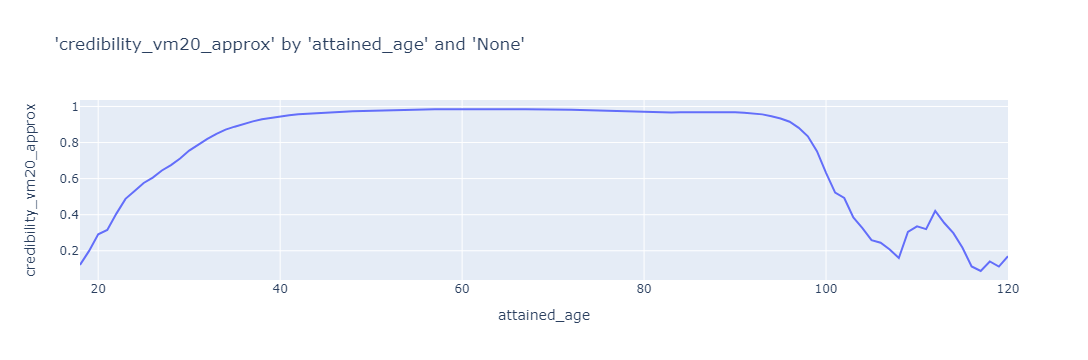

In [62]:
charters.chart(
    df=credibility.vm20_buhlmann_approx(
        df=grouped_df,
        a_col="exp_amt_vbt15",
        b_col="cen2momp1wmi_byamt",
        c_col="cen2momp2wmi_byamt",
        groupby_cols=["attained_age"],
    ),
    x_axis="attained_age",
    y_axis="credibility_vm20_approx",
    type="line",
)

# Reload

In [29]:
importlib.reload(charters)

<module 'morai.experience.charters' from 'C:\\Users\\johnk\\Desktop\\github\\morai\\morai\\experience\\charters.py'>

In [ ]:
importlib.reload(custom_logger)

In [ ]:
importlib.reload(forecasters)

In [ ]:
importlib.reload(helpers)

In [ ]:
importlib.reload(metrics)

In [45]:
importlib.reload(credibility)

<module 'morai.experience.credibility' from 'C:\\Users\\johnk\\Desktop\\github\\morai\\morai\\experience\\credibility.py'>

# Utilities

In [69]:
helpers.memory_usage_jupyter(globals=globals()).head(10)

object  size_mb
0          grouped_df   171.30
1                corr     0.00
2          nan_counts     0.00
3                desc     0.00
4      columns_needed     0.00
5  columns_not_needed     0.00
6           variables     0.00
7     pl_parquet_path     0.00
8                open     0.00
9            measures     0.00